The pipeline of vehicle detection consists of:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

(Note: for those first two steps don't forget to normalize features and randomize a selection for training and testing.)

## First we need load data set and show some examples of this data set. Data set contain vehicles and non-vehiclesimages.

Import all components

In [2]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
from sklearn.cross_validation import train_test_split
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.svm import LinearSVC
from tqdm import tqdm
import time
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
print("Done")

-----------------------
None
ffmpeg -version
-----------------------
Done


D:\Software\Anaconda\envs\SDC-custom-1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Show examples

8792


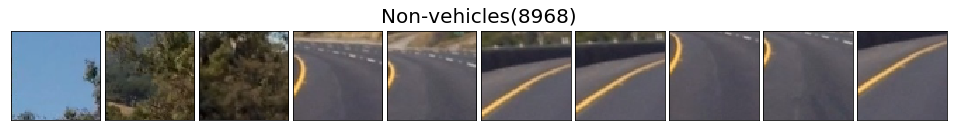

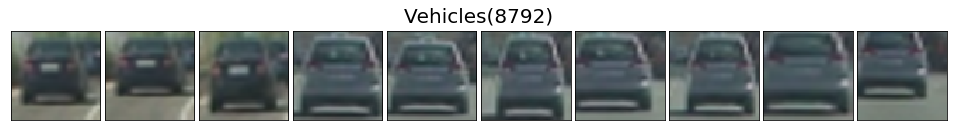

In [3]:
non_vehicles_files = glob.glob("./dataset/non-vehicles/**/*.png")

vehicles_files = glob.glob("./dataset/vehicles/**/*.png")
print(len(vehicles_files))
def show_data_set_examples(files, name, cols=10):
    fig = plt.figure(figsize=(13, 2))
    fig.subplots_adjust(left=0, right=1, wspace=0.05, hspace=0.05)
    for i in range(cols):
        axis = fig.add_subplot(1, cols, i + 1, xticks=[], yticks=[])
        axis.imshow(mpimg.imread(files[i]))

    plt.suptitle("{}({})".format(name, str(len(files))), fontsize=20)
    plt.show()


show_data_set_examples(non_vehicles_files, "Non-vehicles")
show_data_set_examples(vehicles_files, "Vehicles")

## Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

Text(0.5,1,'HOG visualization')

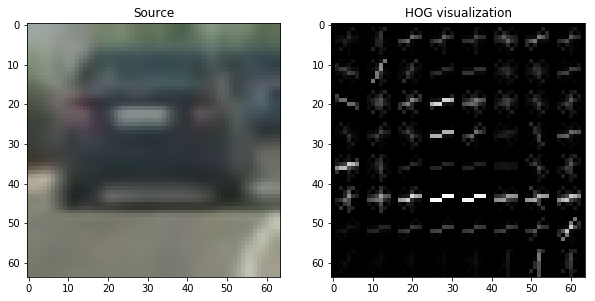

In [4]:
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
        return features


vehicle_img = mpimg.imread(vehicles_files[1])
vehicle_gray_img = cv2.cvtColor(vehicle_img, cv2.COLOR_RGB2GRAY)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

hog_features, hog_img = get_hog_features(vehicle_gray_img, vis=True)

ax[0].imshow(vehicle_img)
ax[0].set_title("Source")

ax[1].imshow(hog_img, cmap='gray')
ax[1].set_title("HOG visualization")




## Extract HOG Features for Input Datasets, Define Labels Vector, Shuffle and Split

Extract features: 100%|███████████████████████████████████████████████████████████| 8968/8968 [00:16<00:00, 553.91it/s]


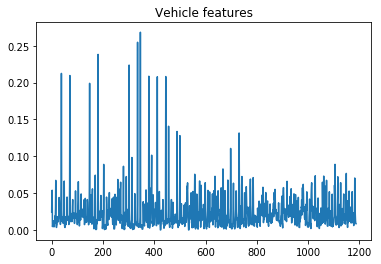

In [5]:
def extract_features(images_files, cspace='RGB', orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0, progress_title="Extract features"):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    pbar = tqdm(total=len(images_files), desc=progress_title)
    for file in images_files:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

            # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list

        pbar.update(1)
        features.append(hog_features)
        
    pbar.close()
    # Return list of feature vectors
    return features


# Feature extraction parameters
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = "ALL"
colorspace = "YUV"

vehicle_features = extract_features(vehicles_files, orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block, hog_channel=hog_channel, cspace=colorspace)
non_vehicles_features = extract_features(non_vehicles_files, orient=orient, pix_per_cell=pix_per_cell,
                                         cell_per_block=cell_per_block, hog_channel=hog_channel, cspace=colorspace)
plt.title("Vehicle features")
plt.plot(vehicle_features[0])
plt.show()


## Split features in train and test data set

In [6]:
X = np.vstack((vehicle_features, non_vehicles_features)).astype(np.float64)
Y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicles_features))))

train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Train size: {}".format(train_labels.shape[0]))
print("Test size: {}".format(test_labels.shape[0]))

print("Done")

Train size: 14208
Test size: 3552
Done


## Train SVC classifier

In [7]:
print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(train_features[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(train_features, train_labels)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(test_features, test_labels), 4))


Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188
0.94 Seconds to train SVC...
Test Accuracy of SVC =  0.9828


## Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [1]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, cspace, draw_all_rect=False):

    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]

    # apply color conversion if other than 'RGB'
    ctrans_tosearch = img_tosearch

    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else:
        ctrans_tosearch = np.copy(img)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    recs = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()

            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            test_prediction = svc.predict(hog_features.reshape(1, -1))

            if test_prediction == 1 or draw_all_rect == True:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                recs.append(((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

    return recs

def draw_boxes(img, boxes, color=(0, 0, 255)):
    draw_img = np.copy(img)
    for box in boxes:
        cv2.rectangle(draw_img, box[0], box[1], color, 6)
    return draw_img


vehicle_img = mpimg.imread("test_images/test1.jpg")

ystart = 400
ystop = 656
scale = 1.5

recs = find_cars(vehicle_img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, colorspace)
plt.figure(figsize=(10, 15))
plt.imshow(draw_boxes(vehicle_img, recs))


NameError: name 'mpimg' is not defined

### We need use different search area and windows, because proportion and size of cars can be different (depends on distance from camera). Implement this technique.

Text(0.5,1,'Example of search regions')

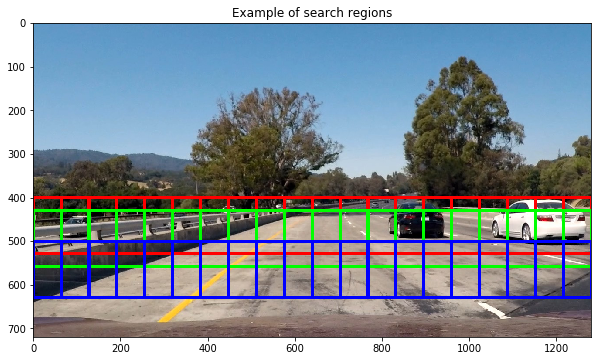

In [9]:
vehicle_img = mpimg.imread("test_images/test1.jpg")

scale = 1.5
ystart = 400
ystop = 530
scale = 2.0

recs1 = find_cars(vehicle_img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, colorspace, True)

ystart = 430
ystop = 560
scale = 2.0

recs2 = find_cars(vehicle_img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, colorspace, True)

ystart = 500
ystop = 650
scale = 2

recs3 = find_cars(vehicle_img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, colorspace, True)

vehicle_img = draw_boxes(vehicle_img, recs1, (255, 0, 0))
vehicle_img = draw_boxes(vehicle_img, recs2, (0, 255, 0))
vehicle_img = draw_boxes(vehicle_img, recs3, (0, 0, 255))

plt.figure(figsize=(10, 15))
plt.imshow(vehicle_img)
plt.title("Example of search regions")

### Use techinique from above cell to imporove search of cars

Text(0.5,1,'Find cars with combinations of search regions')

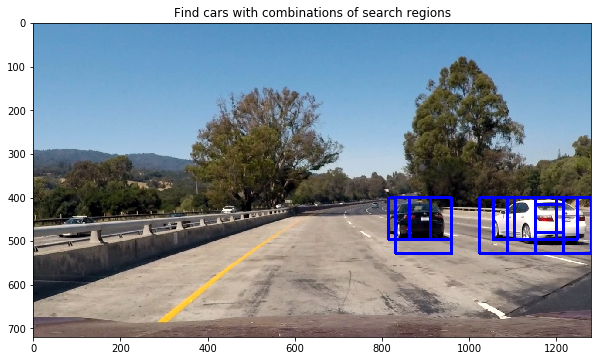

In [10]:
search_regions = [(400, 464, 1.0),
                  (416, 480, 1.0),
                  (400, 496, 1.5),
                  (432, 528, 1.5),
                  (400, 528, 2.0),
                  (432, 560, 2.0),
                  (400, 596, 3.5),
                  (464, 660, 3.5)]


def find_cars_with_search_regions(img, svc, orient, pix_per_cell, cell_per_block, cspace, search_regions):
    boxes = []
    for search_region in search_regions:
        boxes.append(find_cars(img, search_region[0], search_region[1], search_region[2], svc, orient, pix_per_cell,
                               cell_per_block, cspace))
    boxes = [item for sublist in boxes for item in sublist]
    return boxes


vehicle_img = mpimg.imread("test_images/test1.jpg")
boxes = find_cars_with_search_regions(vehicle_img, svc, orient, pix_per_cell, cell_per_block, colorspace, search_regions)
plt.figure(figsize=(10, 15))
plt.imshow(draw_boxes(vehicle_img, boxes))
plt.title("Find cars with combinations of search regions")


##  Run pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

Text(0.5,1,'Final processed frame')

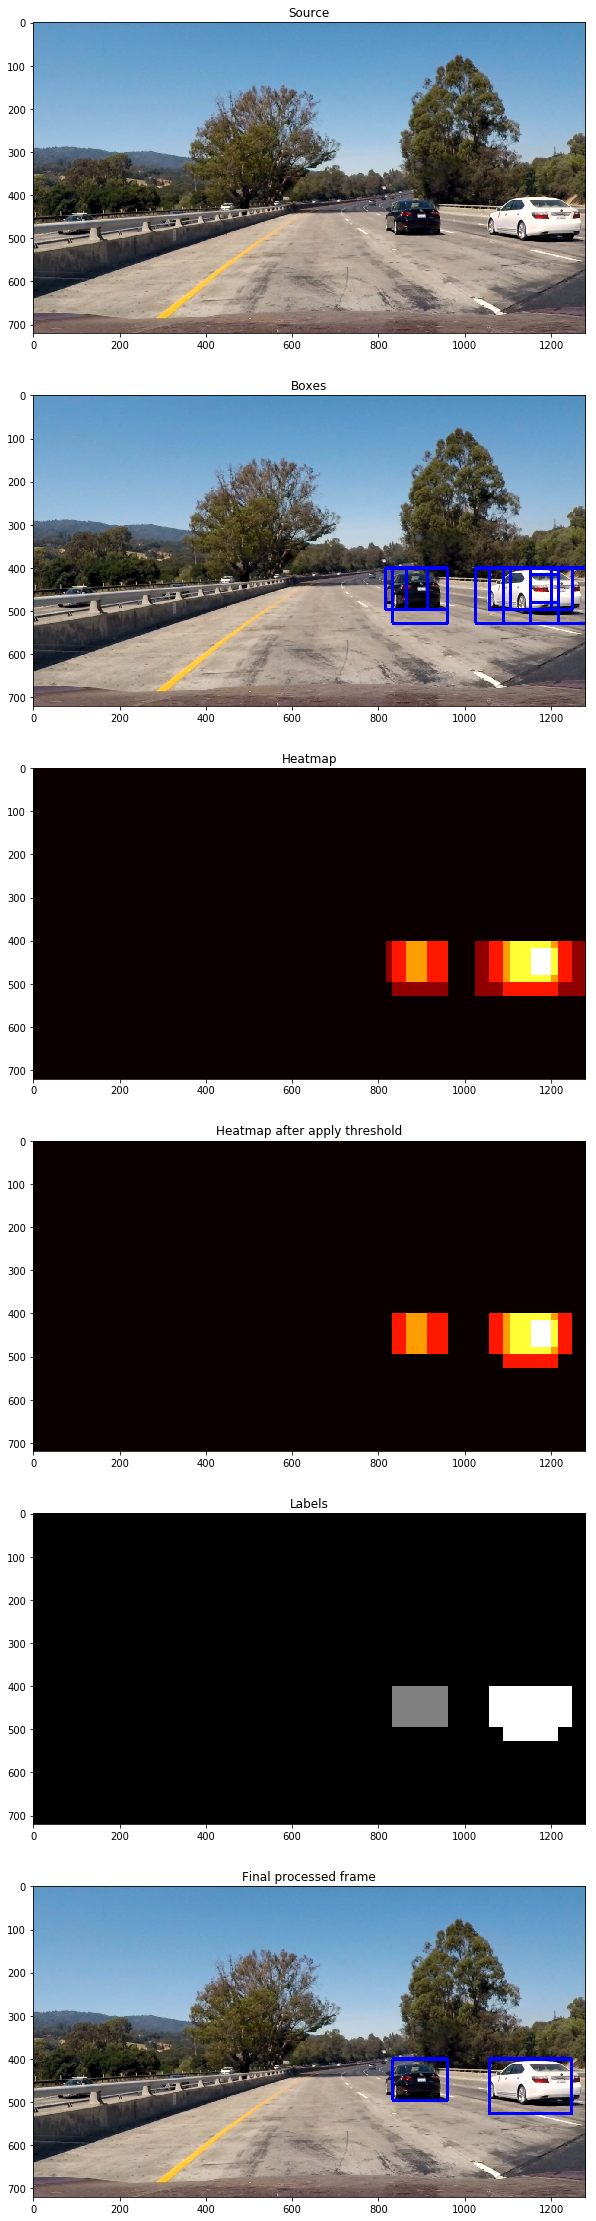

In [11]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap  # Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img



vehicle_img = mpimg.imread("test_images/test1.jpg")

plt.figure(figsize=(23, 40))
plt.subplot(611)
plt.title("Source")
plt.imshow(vehicle_img)

boxes = find_cars_with_search_regions(vehicle_img, svc, orient, pix_per_cell, cell_per_block, colorspace, search_regions)
plt.subplot(612)
plt.title("Boxes")
plt.imshow(draw_boxes(vehicle_img, boxes))


heat = np.zeros_like(vehicle_img[:, :, 0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, find_cars_with_search_regions(vehicle_img, svc, orient, pix_per_cell, cell_per_block, colorspace, search_regions))
plt.subplot(613)
plt.title("Heatmap")
plt.imshow(heat, cmap="hot")

# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)
heatmap = np.clip(heat, 0, 255)
plt.subplot(614)
plt.title("Heatmap after apply threshold")
plt.imshow(heatmap, cmap="hot")

# Find final boxes from heatmap using label function
labels = label(heatmap)
plt.subplot(615)
plt.title("Labels")
plt.imshow(labels[0], cmap="gray")

draw_img = draw_labeled_bboxes(np.copy(vehicle_img), labels)
plt.subplot(616)
plt.imshow(draw_img)
plt.title("Final processed frame")

### Make function which will be process frames from video and process all video

In [33]:
#This variable need for storing previous founded boxes of cars
prev_boxes_list = []

def process_frame(img):
    global prev_boxes_list
    # Add heat to each box in box list
    boxes = find_cars_with_search_regions(img, svc, orient, pix_per_cell, cell_per_block, colorspace, search_regions)
    
    if len(boxes) > 0:
        prev_boxes_list.append(boxes)
        
    if len(prev_boxes_list) > 13:
        prev_boxes_list = prev_boxes_list[len(prev_boxes_list) - 13:]
    
    heat = np.zeros_like(img[:, :, 0]).astype(np.float)
    
    for boxes in prev_boxes_list:    
        heat = add_heat(heat, boxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 3)

    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

video_out_file = "project_processed_video.mp4"
video = VideoFileClip("project_video.mp4")
video = video.fl_image(process_frame)
%time video.write_videofile(video_out_file, audio=False)


[MoviePy] >>>> Building video project_processed_video.mp4
[MoviePy] Writing video project_processed_video.mp4


100%|█████████▉| 1260/1261 [05:46<00:00,  3.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_processed_video.mp4 

CPU times: user 5min 34s, sys: 39.2 s, total: 6min 14s
Wall time: 5min 46s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_out_file))

<video width="960" height="540" controls>
  <source src="project_processed_video.mp4">
</video>